<a href="https://colab.research.google.com/github/fakhrulfaiz/hands_on_machine_learning/blob/main/emotions_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import huggingface_hub

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [3]:
%pip install kagglehub[pandas-datasets]

In [4]:
# Install if needed
# pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Correct file name
file_path = "synthetic_emotions.csv"

# Load dataset using the new API
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "prashanthan24/synthetic-emotions-dataset-14k-texts-7-emotions",
    file_path,
)

print(df.head())
print(df.shape)


100%|██████████| 3.75M/3.75M [00:00<00:00, 7.10MB/s]


                                                text emotion
0  As the sun dipped below the horizon, painting ...    Love
1  As she gazed into her partner's eyes, a warm g...    Love
2  As she gazed into his eyes, her heart fluttere...    Love
3  The warm rays of sunlight filtering through th...    Love
4  Her eyes sparkled with a radiant warmth as she...    Love
(13970, 2)


In [5]:
df['emotion'].unique()

array(['Love', 'Sad', 'Anger', 'Fun', 'Hate', 'Surprise', 'Happiness'],
      dtype=object)

In [6]:
label2id = {
    "Love": 0,
    "Sad": 1,
    "Anger": 2,
    "Fun": 3,
    "Hate": 4,
    "Surprise": 5,
    "Happiness": 6
}

id2label = {v: k for k, v in label2id.items()}

df["label"] = df["emotion"].map(label2id)


In [7]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

train_df_full, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# 2. Split the 'X_train_full' data into final train (75% of the 80% = 60% total)
#    and validation (25% of the 80% = 20% total) sets
train_df, val_df = train_test_split(
    train_df_full,
    test_size=0.25,
    stratify=train_df_full["label"],
    random_state=42
)



In [8]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased"
)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df[["text", "label"]])
val_ds = Dataset.from_pandas(val_df[["text", "label"]])

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

train_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

val_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


Map:   0%|          | 0/8382 [00:00<?, ? examples/s]

Map:   0%|          | 0/2794 [00:00<?, ? examples/s]

In [10]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=7,
    id2label=id2label,
    label2id=label2id
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }


In [12]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    report_to="none"
)


In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-1482414042.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.059100,0.035005,0.991052,0.991079
2,0.019100,0.021441,0.994631,0.994643
3,0.001800,0.021028,0.995705,0.995715
4,0.001200,0.024643,0.994273,0.994285


TrainOutput(global_step=2096, training_loss=0.07557613266994537, metrics={'train_runtime': 434.9134, 'train_samples_per_second': 77.091, 'train_steps_per_second': 4.819, 'total_flos': 1110440742377472.0, 'train_loss': 0.07557613266994537, 'epoch': 4.0})

In [14]:
trainer.evaluate(train_ds)
trainer.evaluate(val_ds)


{'eval_loss': 0.02102782018482685,
 'eval_accuracy': 0.9957050823192556,
 'eval_macro_f1': 0.9957151478971233,
 'eval_runtime': 9.8578,
 'eval_samples_per_second': 283.431,
 'eval_steps_per_second': 17.752,
 'epoch': 4.0}

In [15]:
test_ds = Dataset.from_pandas(test_df[["text", "label"]])
test_ds = test_ds.map(tokenize, batched=True)

test_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

Map:   0%|          | 0/2794 [00:00<?, ? examples/s]

In [23]:
# Evaluate on test dataset
test_results = trainer.evaluate(test_ds)

print("Test Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")


Test Results:
eval_loss: 0.0259
eval_accuracy: 0.9946
eval_macro_f1: 0.9946
eval_runtime: 9.8833
eval_samples_per_second: 282.7000
eval_steps_per_second: 17.7070
epoch: 4.0000


In [24]:
import pandas as pd

# Convert log history to DataFrame
log_history = pd.DataFrame(trainer.state.log_history)
log_history.head()


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_macro_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.4290,2.803806,0.000020,0.095420,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.4719,3.577687,0.000019,0.190840,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.1559,0.494908,0.000019,0.286260,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0932,0.439596,0.000018,0.381679,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0934,0.353712,0.000018,0.477099,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


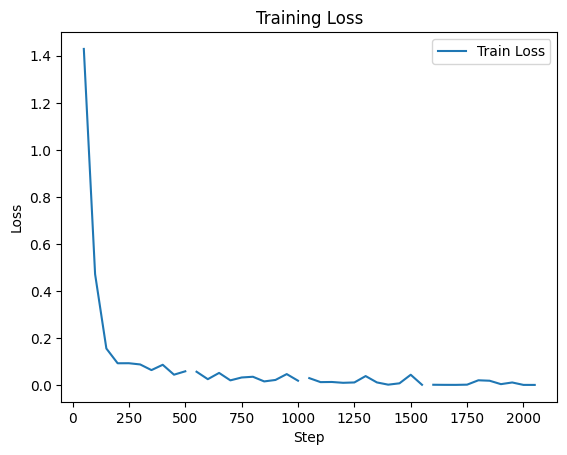

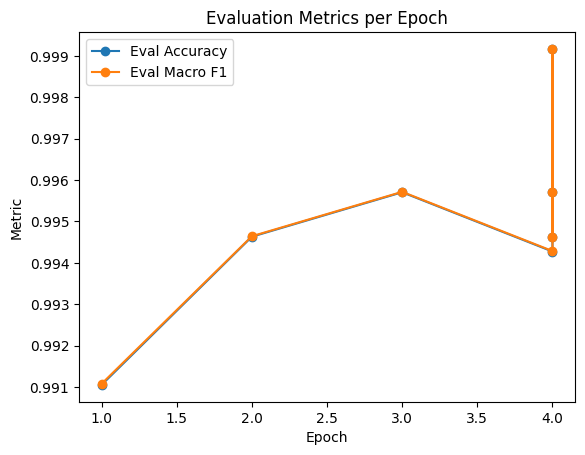

In [25]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(log_history['step'], log_history['loss'], label='Train Loss')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot evaluation accuracy / macro F1
eval_logs = log_history.dropna(subset=['eval_accuracy'])  # keep only eval rows

plt.plot(eval_logs['epoch'], eval_logs['eval_accuracy'], marker='o', label='Eval Accuracy')
plt.plot(eval_logs['epoch'], eval_logs['eval_macro_f1'], marker='o', label='Eval Macro F1')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Evaluation Metrics per Epoch")
plt.legend()
plt.show()


In [27]:
trainer.save_model("./emotion-distilbert-7class")
tokenizer.save_pretrained("./emotion-distilbert-7class")


('./emotion-distilbert-7class/tokenizer_config.json',
 './emotion-distilbert-7class/special_tokens_map.json',
 './emotion-distilbert-7class/vocab.txt',
 './emotion-distilbert-7class/added_tokens.json')

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("./emotion-distilbert-7class")
tokenizer = AutoTokenizer.from_pretrained("./emotion-distilbert-7class")


In [20]:
import torch

def predict(text):
    # Get the device of the model (GPU or CPU)
    device = next(model.parameters()).device

    # Tokenize input and send to the same device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class_id = logits.argmax().item()

    # Convert numeric prediction to emotion label
    return id2label[predicted_class_id]



In [30]:

print(predict("I feel amazing today!"))


Happiness


In [22]:
import gradio as gr

iface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
    outputs=gr.Label(num_top_classes=len(label2id)),
    title="Emotion Classifier",
    description="Enter a sentence and the model predicts the emotion."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1dc9e1722069260f26.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [35]:
from huggingface_hub import login


login()  # paste your token here

# Push the trained model & tokenizer to your HF account
trainer.push_to_hub("fakhrulfaiz201/emotion-distilbert-7class")

# or manually
model.push_to_hub("fakhrulfaiz201/emotion-distilbert-7class")
tokenizer.push_to_hub("fakhrulfaiz201/emotion-distilbert-7class")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...results/training_args.bin: 100%|##########| 5.78kB / 5.78kB            

  ...results/model.safetensors:  13%|#2        | 33.5MB /  268MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...-7class/model.safetensors:   9%|9         | 25.1MB /  268MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/fakhrulfaiz201/emotion-distilbert-7class/commit/12fe3f031b43717c718dfcd60722630857ca47ef', commit_message='Upload tokenizer', commit_description='', oid='12fe3f031b43717c718dfcd60722630857ca47ef', pr_url=None, repo_url=RepoUrl('https://huggingface.co/fakhrulfaiz201/emotion-distilbert-7class', endpoint='https://huggingface.co', repo_type='model', repo_id='fakhrulfaiz201/emotion-distilbert-7class'), pr_revision=None, pr_num=None)